# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Project Overview

Starbucks often sends promotions to its custoners.  Normally, there are 3 different types of promotions: Buy One Get One Free (BOGO), Discount or Informational.  Not all customers get the same offer.  In this project, I would like to analyze the 3 data files provided by Starbucks/Udacity, build a data model to predict a customer's response to an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import math
import json
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Check portfolio data file
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
# split channel into different attribute
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))

for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

# Drop "channels" column
portfolio = portfolio.drop('channels', axis=1)

# Rename 'id' column to 'offer_id'
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# Change the unit of 'duration' column from days to hours
portfolio['duration'] = portfolio['duration']*24
portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,social,mobile
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [4]:
# check profile data file
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [5]:
# check nan value
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
# Replace nan with avg for "income"
#profile['income'].fillna((profile['income'].mean()), inplace=True)

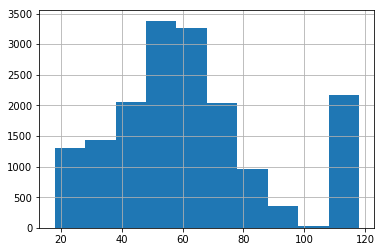

In [7]:
# check distribution of age column
profile.age.hist()

Starbucks customers are from teenagers to senior citizens, most of the customers are between 30 years old and 78 years old.

In [8]:
# check the # of customers at age = '118'
profile['age'][profile['age'] == 118].count()

2175

In [9]:
# check # of male customers vs. # of female customers
#profile.gender.value_counts()

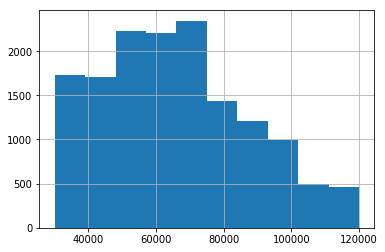

In [10]:
# check distribution of 'income' column
profile['income'].hist()

The customers’ income ranges from less than $30,000 to about $120,000, the majority is between $50,000 to about $75,000.

In [11]:
# check transcript data file
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


# Data Processing

1. Create a cleaned profile data from the original file by:
a. renaming "id" to "customer_id" for easy understanding and merger with other file(s) later on
b. extracting "year", "month", "day" from "became_member_on" and adding them as separate columns
c. extracting "m", "f" from "gender" and adding them as separate columns
d. dividing "age" into different groups, and adding each group as a separate columns

In [12]:
# rename 'id' column to 'customer_id'
profile.rename(columns= {'id':'customer_id'}, inplace=True)

# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

# Parse to datetime became_member_on column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str).astype('datetime64[ns]'))

# Extract year, month and day from became_member_on 
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile['day'] = profile['became_member_on'].dt.day
profile.drop(['became_member_on'], axis=1, inplace = True)

profile = pd.concat([profile, pd.get_dummies(profile['gender'], prefix='gender')], axis=1)

# Discretize age feature (segment and sort)
profile['age_separation']=pd.cut(x=profile['age'], bins=[0,10,20,30,40,50,60,70,80,90,100,110])

# Concat the new columns to profile dataset
profile = pd.concat([profile, pd.get_dummies(profile['age_separation'], prefix='age')], axis=1)

profile.head()

,age,gender,customer_id,income,year,month,day,gender_F,gender_M,gender_O,...,"age_(10, 20]","age_(20, 30]","age_(30, 40]","age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]"
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,0,1,0,...,0,0,0,0,0,1,0,0,0,0
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [42]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 20 columns):
age               14825 non-null int64
customer_id       14825 non-null object
income            14825 non-null float64
year              14825 non-null int64
month             14825 non-null int64
day               14825 non-null int64
gender_F          14825 non-null uint8
gender_M          14825 non-null uint8
gender_O          14825 non-null uint8
age_(0, 10]       14825 non-null uint8
age_(10, 20]      14825 non-null uint8
age_(20, 30]      14825 non-null uint8
age_(30, 40]      14825 non-null uint8
age_(40, 50]      14825 non-null uint8
age_(50, 60]      14825 non-null uint8
age_(60, 70]      14825 non-null uint8
age_(70, 80]      14825 non-null uint8
age_(80, 90]      14825 non-null uint8
age_(90, 100]     14825 non-null uint8
age_(100, 110]    14825 non-null uint8
dtypes: float64(1), int64(4), object(1), uint8(14)
memory usage: 1013.4+ KB


In [13]:
# Drop gender and age_separation columns
profile.drop(['gender'], axis = 1, inplace = True)
profile.drop(['age_separation'], axis = 1, inplace = True)

profile.head()

,age,customer_id,income,year,month,day,gender_F,gender_M,gender_O,"age_(0, 10]","age_(10, 20]","age_(20, 30]","age_(30, 40]","age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]"
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,0,0,0,0,0,0,0,1,0,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,0,1,0,0,0,0,0,0,0,1,0,0,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,0,1,0,0,0,0,0,0,0,1,0,0,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,0,1,0,0,0,0,0,0,1,0,0,0,0,0


Create a cleaned portfolio file by extracting "bogo", "discount", "informational" from "offer_type" and adding them as separate columns

In [14]:
# One-hot encoding offer_type categorical column
portfolio_clean = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)
portfolio_clean.drop(['offer_type'], axis=1, inplace = True)
portfolio_clean

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


Create a cleaned transcript data from the original file by:
a. renaming "person" to "customer_id" 
b. extracting the multiple keys from "value" column and adding each key as a separate column
c. checking the "event", saving "transaction" event into a new data frame and saving the other types of events into another data frame

In [15]:
# Rename person column to customer_id (identical than portfolio dataset to make the join later)
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# transcript: create separate columns for amount and offer_id from value col.
def create_offer_id_col(value_column):
    '''
    INPUT 
        value_column - transcript.value column dictionary
        
    OUTPUT
        Return value_column dictionary values in offer_column_names list keys
    '''
    offer_column_names = ['offer id', 'offer_id']
    
    if list(value_column.keys())[0] in offer_column_names:
        return list(value_column.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = [d.get('amount') for d in transcript.value]

# change amount column type to float
transcript.amount.astype('float')

transcript.drop(['value'], axis= 1, inplace=True)
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


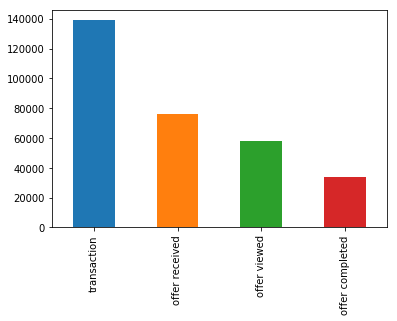

In [16]:
transcript['event'].value_counts().plot(kind='bar')
plt.show()

In [17]:
# change amount column type to float
transcript.time.astype('float')

# Parse time column: hours to days
transcript['time_in_days'] = (transcript['time'] / 24.0)
transcript.drop(['time'], axis=1, inplace=True)


# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

# Extract transcript dataset rows when they are offer xxxxx in event column
offer_tr = transcript[transcript.event != 'transaction'].copy()
offer_tr.drop(['amount'], axis=1, inplace=True)

# One-hot encoding for event categorical feature 
offer_tr_cl = pd.concat([offer_tr, pd.get_dummies(offer_tr.event)], axis=1)

# Drop event column
offer_tr_cl.drop(['event'], axis=1, inplace=True)

# Show offer_tr_cl dataset
offer_tr_cl.head()

,customer_id,offer_id,time_in_days,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0


In [18]:
# Extract transcript rows when event is a transaction
transaction_tr = transcript[transcript.event == 'transaction'].copy()

# Then drop offer_id column (this column belongs to event = offer xxxxx)
transaction_tr.drop(['offer_id'], axis=1, inplace=True)

transaction_tr.head()

,event,customer_id,amount,time_in_days
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.83,0.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0.0
12659,transaction,54890f68699049c2a04d415abc25e717,13.23,0.0
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,18.97,0.0


Merge the data files 

In [19]:
# Merge profile and offer_tr_cl on customer_id column
offer_profile = pd.merge(profile, offer_tr_cl, on='customer_id', how='inner')

# Check for offer_tr_cl and offer_profile datasets
offer_tr_cl.shape[0] == offer_profile.shape[0]

# Merge profile and transaction_tr on customer_id column
transaction_profile = pd.merge(profile, transaction_tr, on='customer_id', how='inner')

# Get a value for separate outliers than allowed amounts 
max_outlier = transaction_profile['amount'].quantile(0.995)
max_outlier

50.97420000000013

In [20]:
# Impute the median value for outliers (will be outliers amounts greatests than max_outlier)
transaction_profile['amount'] = np.where(transaction_profile['amount'] > max_outlier, 
                                         transaction_profile['amount'].mean(), transaction_profile['amount'])

# Check after outliers are fixed
transaction_profile['amount'].describe()

count    123957.000000
mean         12.310139
std           9.588845
min           0.050000
25%           3.660000
50%          10.800000
75%          18.950000
max          50.950000
Name: amount, dtype: float64

In [21]:
# Calculate correlation between age, income and amount variables
corr = transaction_profile[['age', 'income', 'amount']].corr()

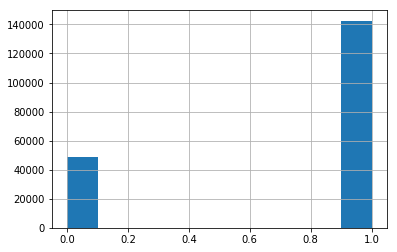

In [23]:
# Support function. Get the target feature: successful offer
def get_offer_succesful(offer_completed_data_df, offer_viewed_data_df, start_time, end_time):
    
    # get completed offers within end date
    offer_completed_withintime = np.logical_and(
    offer_completed_data_df['time_in_days'] >= start_time, offer_completed_data_df['time_in_days'] <= end_time)
            
    # get viewed offers within end date
    offer_viewed_withintime = np.logical_and(
    offer_viewed_data_df['time_in_days'] >= start_time, offer_viewed_data_df['time_in_days'] <=end_time)

    # offer successful is boolean (1/0): offer_successful is 1 if an offer is viewed and completed within end time, else to 0
    offer_successful = offer_completed_withintime.sum() > 0 and offer_viewed_withintime.sum() > 0
            
    # return the target feature
    return offer_successful

# Support function. Get the customer transaction data
def get_customer_transaction_data(customer_transaction_data_df, start_time, end_time):
    
    # extract transactions occured within time
    transaction_withintime = np.logical_and(
    customer_transaction_data_df['time_in_days'] >= start_time, customer_transaction_data_df['time_in_days'] <= end_time)
        
    transaction_data = customer_transaction_data_df[transaction_withintime]
    
    return transaction_data

# Support function. Get the combined data rows to dictionary
def get_rows(rows, row, offer_row, customer):
                  
    row.update(offer_row.iloc[0,0:].to_dict())
    row.update(customer.iloc[0,:].to_dict())
    rows.append(row)
            
    return rows

# Main function. Get the combined data between offers, transactions and customers.
def get_merged_df(profile, portfolio, offer_profile, transaction_profile):
    '''
    INPUT 
        profile - cleaned profile dataset
        portfolio - cleaned portfolio dataset
        offer_profile - offer_profile dataset
        transaction_profile - transaction_profile dataset
        
    OUTPUT
        Return a combined dataset with the most interesting features to build classification models
    '''
    merged_df = []
    customer_ids = offer_profile['customer_id'].unique()
    
     # loop through all customer ids in offer received dataset
    for ind in range(len(customer_ids)):
        # get customer
        customer_id = customer_ids[ind]
        
        # get customer from profile dataset
        customer = profile[profile['customer_id']==customer_id]
        
        # get customer_offer_data from offer_profile dataset
        customer_offer_data = offer_profile[offer_profile['customer_id']==customer_id]
        
        # get customer_transaction_data from transaction_profile dataset
        customer_transaction_data = transaction_profile[transaction_profile['customer_id']==customer_id]
        
        # get received, completed and viewed offer data from customer_offer_data dataset
        offer_received_data = customer_offer_data[customer_offer_data['offer received'] == 1]
        offer_completed_data = customer_offer_data[customer_offer_data['offer completed'] == 1]
        offer_viewed_data = customer_offer_data[customer_offer_data['offer viewed'] == 1]
        
        empty_rows = []
        
     # loop for offer receiveds
        for i in range(offer_received_data.shape[0]):
            
            # get offer id from offer_received_data dataset
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # get offer row from portfolio datset
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # set up start and end time from offer_received_data dataset
            start_time = offer_received_data.iloc[i]['time_in_days']
            end_time = start_time + duration_days
           
            # get offer_successful
            offer_successful = get_offer_succesful(offer_completed_data, offer_viewed_data, start_time, end_time)
            
            # get transaction data
            transaction_data = get_customer_transaction_data(customer_transaction_data, start_time, end_time)
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': customer_id,
                'time_in_days': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            rows = get_rows(empty_rows, row, offer_row, customer)
            
            merged_df.extend(rows)
    
    return pd.DataFrame(merged_df)


# get data combined dataset
merged_df = get_merged_df(profile, portfolio_clean, offer_profile, transaction_profile)

merged_df.offer_successful.hist()

In [24]:
merged_df.head()

,age,"age_(0, 10]","age_(10, 20]","age_(100, 110]","age_(20, 30]","age_(30, 40]","age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]",...,mobile,month,offer_id,offer_successful,reward,social,time_in_days,total_amount,web,year
0,55,0,0,0,0,0,0,1,0,0,...,1,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0,17.0,23.22,1,2017
1,55,0,0,0,0,0,0,1,0,0,...,1,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0,17.0,23.22,1,2017
2,55,0,0,0,0,0,0,1,0,0,...,1,7,3f207df678b143eea3cee63160fa8bed,0,0,0,21.0,23.22,1,2017
3,75,0,0,0,0,0,0,0,0,1,...,1,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,159.27,1,2017
4,75,0,0,0,0,0,0,0,0,1,...,1,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,159.27,1,2017


In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190964 entries, 0 to 190963
Data columns (total 34 columns):
age                 190964 non-null int64
age_(0, 10]         190964 non-null int64
age_(10, 20]        190964 non-null int64
age_(100, 110]      190964 non-null int64
age_(20, 30]        190964 non-null int64
age_(30, 40]        190964 non-null int64
age_(40, 50]        190964 non-null int64
age_(50, 60]        190964 non-null int64
age_(60, 70]        190964 non-null int64
age_(70, 80]        190964 non-null int64
age_(80, 90]        190964 non-null int64
age_(90, 100]       190964 non-null int64
bogo                190964 non-null int64
customer_id         190964 non-null object
day                 190964 non-null int64
difficulty          190964 non-null int64
discount            190964 non-null int64
duration            190964 non-null int64
email               190964 non-null int64
gender_F            190964 non-null int64
gender_M            190964 non-null int64
gender

Calculate the success rate

In [26]:
# Get the success percentage of every offers
def get_success_percentage_df(df1, df2):
    
    '''
    INPUT 
        df1 - combined data dataset
        df2 - cleaned portfolio dataset
    OUTPUT
        Displays a ranking of successful offers by percentage 
    '''
    
    #get success and offer counts
    success_count = df1[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = df1['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    success_count = success_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    # Merge offer and success count on offer_id
    offer_success_tax = pd.merge(offer_count, success_count, on="offer_id")

    # calculate success percentage
    offer_success_tax['success_percentage'] = (100 * offer_success_tax['offer_successful'] 
                                                   / offer_success_tax['count'])

    # Merge offer_success_tax and cleaned portfolio dataset on offer_id
    offer_success_tax = pd.merge(offer_success_tax, df2, on="offer_id")

    # Drop offer_successful column 
    offer_success_tax.drop(columns=['offer_successful'], inplace = True)

    # Sort by success_percentage column
    offer_success_tax.sort_values('success_percentage', ascending=False, inplace= True)

    # return offer success tax data
    return offer_success_tax.reset_index(drop=True)

# Get the offer success tax dataframe
offer_success_tax_df = get_success_percentage_df(merged_df, portfolio_clean)

# Show offer success tax dataframe
offer_success_tax_df

,offer_id,count,success_percentage,difficulty,duration,reward,web,email,social,mobile,bogo,discount,informational
0,fafdcd668e3743c1bb461111dcafc2a4,19095,82.974601,10,240,2,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,19005,82.667719,7,168,3,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,18927,80.134200,5,120,5,1,1,1,1,1,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,19091,75.470117,5,168,5,1,1,0,1,1,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,18812,75.249841,10,120,10,1,1,1,1,1,0,0
5,ae264e3637204a6fb9bb56bc8210ddfd,19236,75.197546,10,168,10,0,1,1,1,1,0,0
6,2906b810c7d4411798c6938adc9daaa5,19159,73.224072,10,168,2,1,1,0,1,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,19397,69.773676,20,240,5,1,1,0,0,0,1,0
8,5a8bc65990b245e5a138643cd4eb9837,19083,66.855316,0,72,0,0,1,1,1,0,0,1
9,3f207df678b143eea3cee63160fa8bed,19159,65.081685,0,96,0,1,1,0,1,0,0,1


# Data Modeling

1. Define function to split data into training and testing sets.
2. Define function to build the model
3. Two algorithms are used: Logistic Regression and Random Forest
4. For metrics, I use: accuracy, precision, recall, F1-score
5. For refinement, I use RandowSearchCV with 10 iterations to optimize the training time

In [27]:
def calculate_test_and_train(features, target, test_size, scaler = False):
    '''
    INPUT 
        features - features dataset
        target - target / class feature dataset
        test_size - split test size percentage
        scaler - if True applies MinMaxScaler function. False by default
        
    OUTPUT
        Returns train and test splits
    '''
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=test_size, random_state=42)
    
    if (scaler):
        scaler = MinMaxScaler()
        #transform data
        X_train = scaler.fit_transform(X_train)

    # convert train and test labels to array
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

In [28]:
def build_model(algorithm, grid_params, scorer, X_train, y_train):
    '''
    Apply RandomizedSearchCV and build the model algorithm with the passed parameters.
    
    INPUT 
        algorithm - algorithm used to create a model
        grid_params - set of grid params
        scorer - scorer
        X_train - train matrix of features
        y_train - train array of the class feature
        
    OUTPUT
        Return the fitted model
    '''
    lr_random = RandomizedSearchCV(
        estimator = algorithm, 
        
        param_distributions = grid_params, 
        scoring=scorer, 
        n_iter = 10, 
        cv = 3, 
        verbose=2, 
        random_state=42, 
        n_jobs = 3)

    # fit train data to the model
    lr_random.fit(X_train, y_train)
    
    return lr_random

In [29]:
# Support function get class classifier name
def get_class_name(clf):
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    
    return class_name

In [30]:
# Calculate and show model metrics on demand
def show_model_metrics(clf, X_test, y_test, full_outcome = True):
    '''
    Show the main metrics of the model
    
    INPUT 
        clf - classifier model 
        X_test - test features matrix
        y_test - test target feature array
        full_outcome - if True returns the full metrics outcome
    OUTPUT
        Return model metrics
    '''
    class_name = get_class_name(clf)

    y_pred_rf = clf.predict(X_test)

    clf_accuracy = accuracy_score(y_test, y_pred_rf)
    clf_f1_score = f1_score(y_test, y_pred_rf)
    
    precision = precision_score(y_test, y_pred_rf)
    
    recall = recall_score(y_test, y_pred_rf)
    
    if( full_outcome == True):
        print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
        print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
        print("%s model precision: %.3f" % (class_name, precision))
        print("%s model recall: %.3f" % (class_name, recall))

        sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap='Blues', square=True)
        plt.show()
        
    return clf_accuracy, clf_f1_score, y_pred_rf

In [31]:
# Calculate AUC-ROC curve and show a visualization
def show_roc_auc(algorithm_name, y_test, predicted):
    '''
    Display the ROC visualization
    
    INPUT 
        clf - classifier model 
        X_test - test features matrix
        predicted - targets predicted by the clf
        
    OUTPUT
        ROC plot visualization
    '''
    
    # Calculate AUC-ROC measure
    fpr, tpr, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(fpr, tpr)
    performance_auc[algorithm_name] = roc_auc

    # Show AUC-ROC visualization
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
# Initialize performance array
performance_auc = {}

# get an scorer
scorer = make_scorer(fbeta_score, beta=0.5)


# Prepare features and target
merged_df.drop(columns=['customer_id', 'offer_id', 'total_amount', 'month', 'day'], inplace=True)

class_label_name = 'offer_successful'

split_val =  0.3

features = merged_df.drop(columns=[class_label_name])
target = merged_df.filter([class_label_name])

# get test and train 
X_train, X_test, y_train, y_test = calculate_test_and_train(features, target, split_val)

Logistic Regression

In [33]:
# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# instantiate a logistic regression classifer object
log_reg = LogisticRegression(random_state=42, solver='liblinear')

# Build the logistic regression model
log_reg_random = build_model(log_reg, grid_params, scorer, X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] penalty=l2, C=10 ................................................
[CV] penalty=l2, C=10 ................................................
[CV] penalty=l2, C=10 ................................................
[CV] ................................. penalty=l2, C=10, total=   3.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................................. penalty=l2, C=10, total=   2.9s
[CV] ................................. penalty=l2, C=10, total=   3.3s
[CV] penalty=l2, C=100 ...............................................
[CV] penalty=l2, C=100 ...............................................
[CV] ................................ penalty=l2, C=100, total=   2.6s
[CV] penalty=l1, C=0.001 .............................................
[CV] ................................ penalty=l2, C=100, total=   2.7s
[CV] penalty=l1, C=0.001 .............................................
[CV] ...........

[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:   40.1s finished


In [34]:
log_reg_random.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression model accuracy: 0.762
LogisticRegression model f1-score: 0.858
LogisticRegression model precision: 0.774
LogisticRegression model recall: 0.963


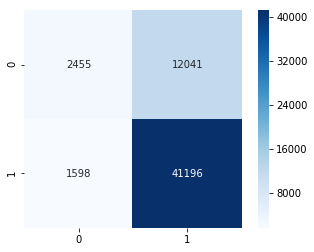

In [35]:
# evaluate logistic regression model's performance
x, y, pred_lr = show_model_metrics(log_reg_random.best_estimator_, X_test, y_test)

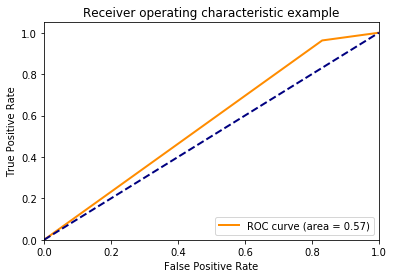

In [36]:
# Call function to display ROC visualization
show_roc_auc('LogisticRegression', y_test, pred_lr)

Random Forest

In [37]:
# instantiate a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300, 350, 500, 1000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 13)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_split_samples = [2, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_split_samples,
               'min_samples_leaf': min_samples_leaf}

In [38]:
# Call function to build the model
rf_random = build_model(rf_clf, random_grid_params, scorer, X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total= 1.4min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total= 1.4min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total= 1.4min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11 
[CV]  n_estimators=1000,

[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 14.9min finished


In [39]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 12}

In [40]:
# Show the best model estimator
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier model accuracy: 0.803
RandomForestClassifier model f1-score: 0.880
RandomForestClassifier model precision: 0.810
RandomForestClassifier model recall: 0.963


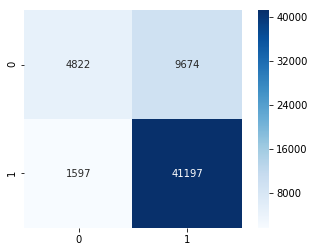

In [41]:
# evaluate random forest classifier model's performance
x, y, pred_rf = show_model_metrics(rf_random.best_estimator_, X_test, y_test)

# Model Evaluation and Validation

In [79]:
# Evaluate model performances
model_performance = []

classifier_type = ['logistic_regression', 'random_forest']
                   #'gradient_boosting',


model_performance.append(show_model_metrics(log_reg_random.best_estimator_, X_test, y_test, full_outcome = False)[:2])

model_performance.append(show_model_metrics(rf_random.best_estimator_, X_test, y_test, full_outcome = False)[:2])

model_performance = pd.DataFrame(model_performance, columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type, columns=['model'])

model_performance = pd.concat([classifier_type, model_performance], axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)

# Show model performance table
model_performance

,model,accuracy,f1score
0,random_forest,0.803264,0.879667
1,logistic_regression,0.761931,0.857973


# Conclusion

In this project, I analyzed the data sets provided by Starbucks, and tried to build a model to predict a customer's response to an offer.  

I started with exploring the data set to understand the provided data, check the missing value.  Then pre-processing the data set to get the clean data for each data file.  The pre-processing took a lot of effort because the data has missing values, mismatch data types, and multiple values in one column.  Once the data are cleaned, I was able to merge them into one data file to do analysis then build the model.  I chose two supervised algorithms: Logistic Regression and Random Forest.  To run the test with each model, I used RandomSearchCV with 10 iterations to optimize the training time. Comparing both accuracy and f1score, Random Forest is better than Logistic Regression.

# Reflection

Doing this project was a challenge, especially the pre-processing part to separate multiple value into different columns, and replacing values with numbers, which took a lot of my time, it is also interesting because I learned a lot by doing it.  

It has been a journey and I enjoyed every bit of it! 

# Improvements

If more data can be collected or less missing data, we might be able to build a model that can predict which kind of offers to be sent to what group of customers(e.g. age group, income range ... etc.).